In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
print(tf.__version__)

2.12.0


## data loading

In [2]:
data_path = "./TCIR-ALL_2017.h5/TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [3]:
data_info.head()

,data_set,ID,lon,lat,time,Vmax,R35_4qAVG,MSLP
0,ATLN,201701L,-50.3,35.8,2017041606,55.0,270.0,992.0
1,ATLN,201701L,-49.9,35.5,2017041609,55.0,270.0,990.0
2,ATLN,201701L,-49.5,35.1,2017041612,55.0,270.0,989.0
3,ATLN,201701L,-49.1,34.8,2017041615,55.0,262.5,988.0
4,ATLN,201701L,-48.7,34.4,2017041618,55.0,255.0,986.0


In [4]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4580 entries, 0 to 4579
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   data_set   4580 non-null   object 
 1   ID         4580 non-null   object 
 2   lon        4580 non-null   float64
 3   lat        4580 non-null   float64
 4   time       4580 non-null   object 
 5   Vmax       4580 non-null   float64
 6   R35_4qAVG  4580 non-null   float64
 7   MSLP       4580 non-null   float64
dtypes: float64(5), object(3)
memory usage: 322.0+ KB


In [5]:
np.shape(data_matrix)

(4580, 201, 201, 4)

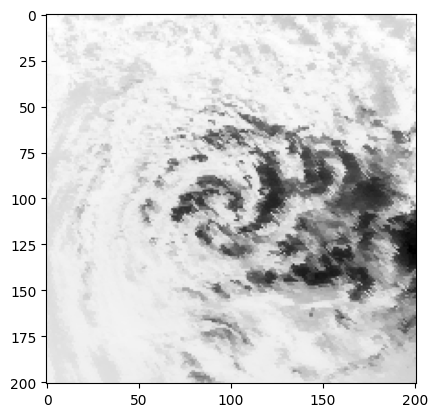

In [6]:
img = data_matrix[17,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

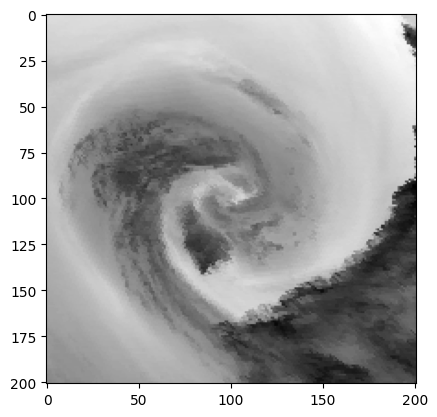

In [7]:
img = data_matrix[4,:,:,1].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

## Data preprocessing

In [8]:
data_matrix.shape

(4580, 201, 201, 4)

In [9]:
## keep only IR and PMW
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [10]:
X_irpmw.shape

(4580, 201, 201, 2)

In [11]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

In [12]:
X_irpmw[np.isnan(X_irpmw)]

array([], dtype=float32)

In [13]:
train_x, test_x, train_y, test_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.2)

In [14]:
kf = KFold(n_splits=2)
for train_index, test_index in kf.split(X_irpmw):
    print("TEST:", len(list(train_index)), type(list(test_index)))
    X_train, X_test = X_irpmw[train_index], X_irpmw[test_index]
    y_train, y_test = y[train_index], y[test_index]

TEST: 2290 <class 'list'>
TEST: 2290 <class 'list'>


In [31]:
X_tensor = tf.convert_to_tensor(X_irpmw)
y = tf.convert_to_tensor(y)

## Preprocessing layers

In [19]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

In [20]:
pp = Preprocessing()

## Building a model

In [23]:
# input_size = len(X_std)
# output_size = 10

"""
references: 
layers API: https://keras.io/api/layers/ 

1. some parameter tuning: 
    batch size: BATCH_SIZE = 128 #@param ["64", "128", "256", "512"]
    regularizer: l1,l2 
    how to set the initial weight: weights_initializer = keras.initializers.GlorotUniform()  
    batch size: 32 
    how to choose metric?  https://www.tensorflow.org/guide/keras/train_and_evaluate  
        right now, I am using mse. 
    what is callback?  https://keras.io/api/callbacks/  
3. 3 fold cross-validation 
4. hold out data for testing 
5. all years data 
"""



#A function that trains and validates the model and returns the MSE
def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    train_X = tf.image.per_image_standardization(train_X)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    val_X = tf.image.per_image_standardization(val_X)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', #Computes the mean of squares of errors between labels and predictions
                  metrics=['mean_squared_error'], #Computes the mean squared error between y_true and y_pred
                 )
    # initialize TimeStopping callback 
#     time_stopping_callback = tfa.callbacks.TimeStopping(seconds=5*60, verbose=1)
    
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1,
         validation_split=0.1,
         #callbacks=[tf.keras.callbacks.TensorBoard(run_dir + "/Keras"), time_stopping_callback]
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow_addons as tfa

# A function that trains and validates the model and returns the MSE
def train_val_model(train_x, train_y, val_x, val_y, n_epochs, batch_size):
    learning_rate = 1e-5
    batch_size = 60
    reg_param = 1e-5

    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)

    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)

    weights_initializer = keras.initializers.GlorotUniform()

    model = keras.models.Sequential([
        Preprocessing(),
        Conv2D(filters=16, kernel_size=4, strides=1, padding='valid', activation='relu', kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=64, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=128, kernel_size=3, strides=1, padding='valid', activation='relu', kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(256, activation='relu', kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        Dense(128, activation='relu', kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        Dense(128, activation='relu', kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)), # Additional dense layer
        Dense(1, activation='linear', kernel_initializer=weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])

    # Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error',  # MSE loss for regression
                  metrics=['mean_squared_error'],
                  )

    # initialize TimeStopping callback
    time_stopping_callback = tfa.callbacks.TimeStopping(seconds=5 * 60, verbose=1)

    # Training the network
    history = model.fit(train_X, train_Y,
                        epochs=n_epochs,
                        batch_size=batch_size,
                        verbose=1,
                        validation_split=0.1,
                        # callbacks=[tf.keras.callbacks.TensorBoard(run_dir + "/Keras"), time_stopping_callback]
                        )

    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ", val_score)
    return history, val_score


F:\cyclone-intensity-prediction\env\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
n_epochs=200
batch_size=60
model_history = []  #save the model history in a list after fitting so that we can plot later
val_scores=[]
kf = KFold(n_splits=5)

i=0
for train_index, test_index in kf.split(X_irpmw):
    print("Training on Fold: ",i+1)
    i+=1
    train_x, val_x = X_irpmw[train_index], X_irpmw[test_index]
    train_y, val_y = y[train_index], y[test_index]
    history,val_score = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
    model_history.append(history)
    val_scores.append(val_score)
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/200
55/55 [==============================] - 22s 366ms/step - loss: 1051.2200 - mean_squared_error: 1051.2108 - val_loss: 865.3439 - val_mean_squared_error: 865.3349
Epoch 2/200
55/55 [==============================] - 19s 340ms/step - loss: 752.0222 - mean_squared_error: 752.0132 - val_loss: 418.0817 - val_mean_squared_error: 418.0727
Epoch 3/200
55/55 [==============================] - 19s 337ms/step - loss: 671.9120 - mean_squared_error: 671.9028 - val_loss: 313.2786 - val_mean_squared_error: 313.2696
Epoch 4/200
55/55 [==============================] - 18s 336ms/step - loss: 650.7372 - mean_squared_error: 650.7284 - val_loss: 451.5006 - val_mean_squared_error: 451.4916
Epoch 5/200
55/55 [==============================] - 18s 337ms/step - loss: 648.5966 - mean_squared_error: 648.5876 - val_loss: 481.6047 - val_mean_squared_error: 481.5958
Epoch 6/200
55/55 [==============================] - 18s 335ms/step - loss: 627.4949 - mean_squared_error: 627.4861 -

55/55 [==============================] - 18s 328ms/step - loss: 267.5793 - mean_squared_error: 267.5710 - val_loss: 232.5738 - val_mean_squared_error: 232.5655
Epoch 49/200
55/55 [==============================] - 19s 339ms/step - loss: 263.2655 - mean_squared_error: 263.2571 - val_loss: 227.4442 - val_mean_squared_error: 227.4359
Epoch 50/200
55/55 [==============================] - 17s 311ms/step - loss: 262.8626 - mean_squared_error: 262.8543 - val_loss: 235.5289 - val_mean_squared_error: 235.5205
Epoch 51/200
55/55 [==============================] - 18s 319ms/step - loss: 260.5337 - mean_squared_error: 260.5254 - val_loss: 300.1551 - val_mean_squared_error: 300.1468
Epoch 52/200
55/55 [==============================] - 18s 333ms/step - loss: 255.9832 - mean_squared_error: 255.9749 - val_loss: 245.9128 - val_mean_squared_error: 245.9044
Epoch 53/200
55/55 [==============================] - 19s 340ms/step - loss: 250.9773 - mean_squared_error: 250.9690 - val_loss: 261.5615 - val_mean

55/55 [==============================] - 18s 336ms/step - loss: 175.3381 - mean_squared_error: 175.3298 - val_loss: 161.3287 - val_mean_squared_error: 161.3205
Epoch 96/200
55/55 [==============================] - 18s 329ms/step - loss: 173.1008 - mean_squared_error: 173.0926 - val_loss: 258.1893 - val_mean_squared_error: 258.1811
Epoch 97/200
55/55 [==============================] - 18s 327ms/step - loss: 170.6792 - mean_squared_error: 170.6709 - val_loss: 169.5742 - val_mean_squared_error: 169.5661
Epoch 98/200
55/55 [==============================] - 18s 325ms/step - loss: 163.5272 - mean_squared_error: 163.5190 - val_loss: 241.4017 - val_mean_squared_error: 241.3935
Epoch 99/200
55/55 [==============================] - 18s 329ms/step - loss: 166.9137 - mean_squared_error: 166.9055 - val_loss: 173.8550 - val_mean_squared_error: 173.8468
Epoch 100/200
55/55 [==============================] - 18s 328ms/step - loss: 160.7069 - mean_squared_error: 160.6987 - val_loss: 206.1264 - val_mea

55/55 [==============================] - 19s 346ms/step - loss: 133.6514 - mean_squared_error: 133.6432 - val_loss: 158.6636 - val_mean_squared_error: 158.6555
Epoch 143/200
55/55 [==============================] - 18s 330ms/step - loss: 132.9101 - mean_squared_error: 132.9020 - val_loss: 172.4438 - val_mean_squared_error: 172.4356
Epoch 144/200
55/55 [==============================] - 18s 326ms/step - loss: 130.4107 - mean_squared_error: 130.4026 - val_loss: 174.7689 - val_mean_squared_error: 174.7607
Epoch 145/200
55/55 [==============================] - 19s 338ms/step - loss: 128.5814 - mean_squared_error: 128.5733 - val_loss: 185.2573 - val_mean_squared_error: 185.2492
Epoch 146/200
55/55 [==============================] - 18s 329ms/step - loss: 128.3695 - mean_squared_error: 128.3614 - val_loss: 158.9164 - val_mean_squared_error: 158.9083
Epoch 147/200
55/55 [==============================] - 18s 327ms/step - loss: 128.2655 - mean_squared_error: 128.2574 - val_loss: 172.7359 - val

55/55 [==============================] - 18s 337ms/step - loss: 114.2334 - mean_squared_error: 114.2253 - val_loss: 161.5308 - val_mean_squared_error: 161.5227
Epoch 190/200
55/55 [==============================] - 18s 333ms/step - loss: 111.1916 - mean_squared_error: 111.1835 - val_loss: 142.6971 - val_mean_squared_error: 142.6890
Epoch 191/200
55/55 [==============================] - 18s 334ms/step - loss: 108.3981 - mean_squared_error: 108.3900 - val_loss: 168.4951 - val_mean_squared_error: 168.4871
Epoch 192/200
55/55 [==============================] - 19s 343ms/step - loss: 108.1002 - mean_squared_error: 108.0921 - val_loss: 159.9359 - val_mean_squared_error: 159.9278
Epoch 193/200
55/55 [==============================] - 18s 334ms/step - loss: 105.3957 - mean_squared_error: 105.3876 - val_loss: 141.2512 - val_mean_squared_error: 141.2431
Epoch 194/200
55/55 [==============================] - 18s 326ms/step - loss: 106.4565 - mean_squared_error: 106.4484 - val_loss: 156.0063 - val

Epoch 35/200
55/55 [==============================] - 18s 320ms/step - loss: 404.4177 - mean_squared_error: 404.4106 - val_loss: 436.2840 - val_mean_squared_error: 436.2768
Epoch 36/200
55/55 [==============================] - 18s 321ms/step - loss: 396.7219 - mean_squared_error: 396.7148 - val_loss: 394.3683 - val_mean_squared_error: 394.3612
Epoch 37/200
55/55 [==============================] - 18s 324ms/step - loss: 392.1053 - mean_squared_error: 392.0981 - val_loss: 333.1101 - val_mean_squared_error: 333.1030
Epoch 38/200
55/55 [==============================] - 18s 330ms/step - loss: 392.2084 - mean_squared_error: 392.2014 - val_loss: 391.1089 - val_mean_squared_error: 391.1018
Epoch 39/200
55/55 [==============================] - 18s 322ms/step - loss: 398.8567 - mean_squared_error: 398.8496 - val_loss: 592.5554 - val_mean_squared_error: 592.5485
Epoch 40/200
55/55 [==============================] - 19s 338ms/step - loss: 394.5168 - mean_squared_error: 394.5099 - val_loss: 554.83

55/55 [==============================] - 18s 331ms/step - loss: 259.9512 - mean_squared_error: 259.9454 - val_loss: 269.8255 - val_mean_squared_error: 269.8197
Epoch 83/200
55/55 [==============================] - 18s 333ms/step - loss: 259.9986 - mean_squared_error: 259.9928 - val_loss: 218.0001 - val_mean_squared_error: 217.9943
Epoch 84/200
55/55 [==============================] - 18s 327ms/step - loss: 256.8082 - mean_squared_error: 256.8024 - val_loss: 252.9970 - val_mean_squared_error: 252.9912
Epoch 85/200
55/55 [==============================] - 18s 330ms/step - loss: 254.4030 - mean_squared_error: 254.3972 - val_loss: 247.5288 - val_mean_squared_error: 247.5231
Epoch 86/200
55/55 [==============================] - 18s 330ms/step - loss: 251.5466 - mean_squared_error: 251.5408 - val_loss: 247.4218 - val_mean_squared_error: 247.4161
Epoch 87/200
55/55 [==============================] - 18s 322ms/step - loss: 251.5448 - mean_squared_error: 251.5390 - val_loss: 255.3756 - val_mean

In [48]:
def plot_xy(history,title):
    fig = plt.figure()
    x=range(n_epochs)
    train_mse=history.history['loss']
    val_mse=history.history['val_loss']
    plt.plot(x,train_mse,label="train_mse")
    plt.plot(x,val_mse,label="val_mse")
    plt.xlabel('epochs')
    plt.ylabel('mse (kt^2)')
    plt.title(title)
    plt.legend()

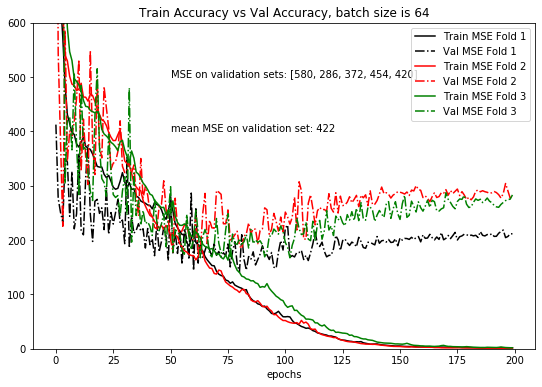

In [149]:
def plot_xy(history,title):
    fig = plt.figure()
    x=range(n_epochs)
    train_mse=history.history['loss']
    val_mse=history.history['val_loss']
    plt.plot(x,train_mse,label="train_mse")
    plt.plot(x,val_mse,label="val_mse")
    plt.xlabel('epochs')
    plt.ylabel('mse (kt^2)')
    plt.title(title)
    plt.legend()

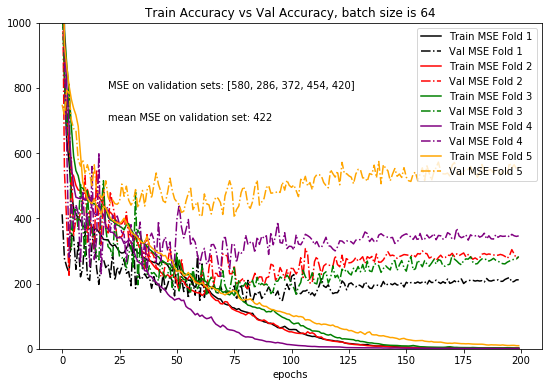

In [151]:
plt.figure(figsize=(9,6))
plt.title('Train Accuracy vs Val Accuracy, batch size is 64')
colors=['black','red','green','purple','orange']
for i in range(5):
    plt.plot(model_history[i].history['mean_squared_error'], label='Train MSE Fold '+str(i+1), color=colors[i])
    plt.plot(model_history[i].history['val_mean_squared_error'], label='Val MSE Fold '+str(i+1), color=colors[i], linestyle = "dashdot")

plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylim(0,1000)
plt.text(20,800,"MSE on validation sets: "+str([int(v) for v,v2 in val_scores]))
plt.text(20,700,"mean MSE on validation set: "+str(int(np.mean(val_scores,axis=0)[0])))
plt.show()

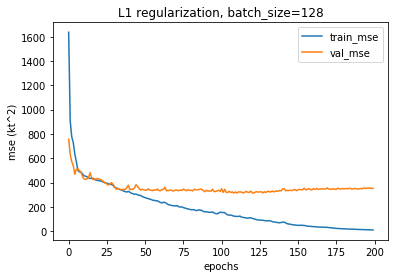

In [55]:
plot_xy(history,"L1 regularization, batch_size=128")

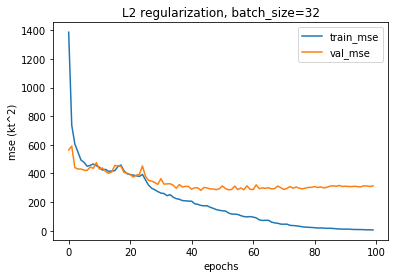

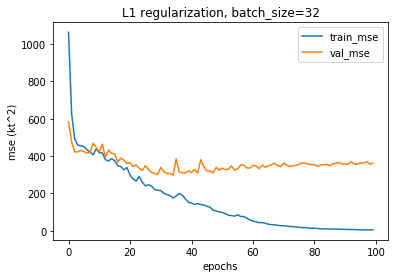

In [49]:
plot_xy(history,"L1 regularization, batch_size=32")

In [ ]:

print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)



In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing_1 (Preprocessi multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  528       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4640      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  18496     
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  73856     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  8

In [43]:
print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
